# Presentation: Introduction to MDAnalysis 

In [1]:
import MDAnalysis as mda
import MDAnalysisData
from MDAnalysisData import datasets

import nglview as nv

import matplotlib.pyplot as plt

print(mda.__version__)
print(MDAnalysisData.__version__)

0.19.2
0.5.0


## Data: I-FABP
As a test data set use a simulation of intestinal fatty acid binding protein (I-FABP)

In [2]:
ifabp = datasets.fetch_ifabp_water()

## Fundamental data structures: Universe 

Create the `Universe`

In [3]:
u = mda.Universe(ifabp.topology, ifabp.trajectory)

In [4]:
print(u)

<Universe with 12445 atoms>


In [5]:
print(repr(u.atoms))

<AtomGroup with 12445 atoms>


##  Fundamental data structures: AtomGroup

In [6]:
protein = u.atoms.select_atoms("protein")
protein

<AtomGroup with 2113 atoms>

In [7]:
print(protein[:5])

<AtomGroup [<Atom 1: N of type 56 of resname ALA, resid 1 and segid IFAB>, <Atom 2: HT1 of type 2 of resname ALA, resid 1 and segid IFAB>, <Atom 3: HT2 of type 2 of resname ALA, resid 1 and segid IFAB>, <Atom 4: HT3 of type 2 of resname ALA, resid 1 and segid IFAB>, <Atom 5: CA of type 22 of resname ALA, resid 1 and segid IFAB>]>


In [8]:
solvshell = u.atoms.select_atoms("resname TIP3 and around 5.0 protein")
solvshell

<AtomGroup with 3868 atoms>

In [9]:
ag = protein + solvshell
ag

<AtomGroup with 5981 atoms>

## AtomGroups: Residues and Segments

In [10]:
protein.residues[10:50]

<ResidueGroup with 40 residues>

In [11]:
print(protein.residues[10:50])

<ResidueGroup [<Residue ASN, 11>, <Residue GLU, 12>, <Residue ASN, 13>, ..., <Residue THR, 48>, <Residue VAL, 49>, <Residue LYS, 50>]>


In [12]:
print(protein.segments)

<SegmentGroup [<Segment IFAB>]>


## Atom data as NumPy arrays  

In [13]:
ag.names

array(['N', 'HT1', 'HT2', ..., 'OH2', 'H1', 'H2'], dtype=object)

In [14]:
ag.charges

array([-0.30000001,  0.33000001,  0.33000001, ..., -0.83399999,
        0.417     ,  0.417     ])

In [15]:
ag.positions

array([[-10.611617  ,  11.658807  ,  -5.231994  ],
       [ -9.685196  ,  12.13134   ,  -5.2246804 ],
       [-11.36631   ,  12.269861  ,  -4.8596344 ],
       ...,
       [ 12.833414  ,  -0.36320674,  28.923624  ],
       [ 12.293991  ,  -0.6852072 ,  29.645824  ],
       [ 12.222381  ,  -0.2635323 ,  28.1936    ]], dtype=float32)

## Basic analysis pattern: Iterate over frames
Iterate over frames in trajectory, analyze positions of an AtomGroup, and collect time series.

In [16]:
import numpy as np
def analyze_bsphere(x):
    center = x.mean(axis=0)
    r = np.linalg.norm(x - center, axis=1)
    return np.max(r)

In [17]:
data = []

for ts in u.trajectory[::10]:
    data.append([ts.time, analyze_bsphere(protein.positions)])

data = np.array(data)

In [18]:
data[:5]

array([[ 6.99999938, 24.07069778],
       [16.9999985 , 23.97127533],
       [26.99999762, 24.45705795],
       [36.99999674, 24.39813805],
       [46.99999586, 23.20430565]])

Plot the data (not much interesting is happening here...)

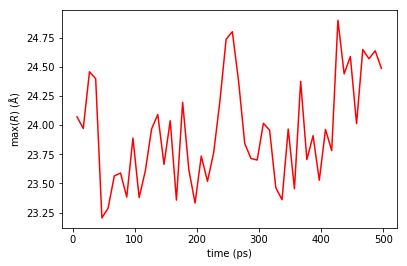

In [19]:
plt.plot(data[:, 0], data[:, 1], 'r-')
plt.xlabel("time (ps)")
plt.ylabel(r"max($R$) (Å)");

### Working with trajectories 

Random access:

In [20]:
u.trajectory[72]

< Timestep 72 with unit cell dimensions [50.0467   46.5632   49.985783 90.       90.       90.      ] >

Length

In [21]:
len(u.trajectory)

500

In [22]:
u.trajectory.n_frames

500

More fancy things...
- fancy and boolean indexing
- on-the-fly transformations
- auxiliary data

## Example: RMSF analysis 

In [23]:
import numpy as np

ca = u.select_atoms("protein and name CA")
means = np.zeros((len(ca), 3))
sumsq = np.zeros_like(means)
for k, ts in enumerate(u.trajectory):
    sumsq += (k/(k+1)) * (ca.positions - means)**2
    means[:] = (k*means + ca.positions)/(k+1)
rmsf = np.sqrt(sumsq.sum(axis=1)/(k+1))

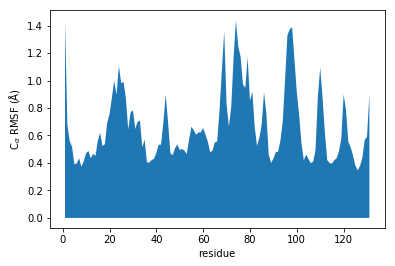

In [24]:
plt.fill_between(ca.residues.resids, rmsf)
plt.xlabel("residue")
plt.ylabel(r"C$_\alpha$ RMSF (Å)");

(Note: the output in the presentation is from the AdK system, not I-FABP, and looks different from the one shown here.)

## Visualization

Visualize PDB structure file:

In [25]:
import MDAnalysis as mda
from MDAnalysisData import datasets as data
import nglview as nv

In [26]:
ifabp = data.fetch_ifabp_water()
u = mda.Universe(ifabp.structure, ifabp.trajectory)
protein = u.select_atoms("protein")

In [27]:
w = nv.show_mdanalysis(protein)
w

NGLWidget(count=500)

Visualizing arbitrary universes: add a few topology attributes that the PDBWriter expects and would warn about. (The PDBWriter is used by the interface to nglviewer.)

In [28]:
u = mda.Universe(ifabp.topology, ifabp.trajectory)
u.add_TopologyAttr("tempfactors")
u.add_TopologyAttr("occupancy")
u.add_TopologyAttr("altLocs")
u.add_TopologyAttr("icodes")

protein = u.select_atoms("protein")

In [29]:
w = nv.show_mdanalysis(protein)
w

NGLWidget(count=500)

## Analysis module 

In [37]:
from MDAnalysis.analysis.rms import RMSF
protein_heavy = u.select_atoms("protein and not name H*")
A = RMSF(protein_heavy).run()

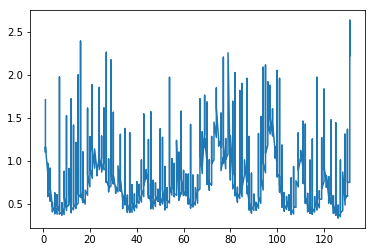

In [38]:
plt.plot(protein_heavy.resids, A.rmsf)

In [40]:
len(mda.__authors__)

83